### Program to read selected Datawell hexadecimal .HVA files
JW 04/19
Hexadecimal format described in DWTP 2.1 p.19

In [1]:
%matplotlib inline

import array as arr
import binascii
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
#import statistics as s
import sys

from datetime import datetime, time, timedelta
#from itertools import count # izip for maximum efficiency
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import tukey
import scipy.stats
from scipy.stats import norm
from statistics import mean
from tkinter import filedialog
from tkinter import *

Sample_frequency = "global"
Sample_rate = "global"
Sample_frequency = 2.56
Sample_rate = 1. / Sample_frequency

In [2]:
def get_file():
# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select HVA or BVA file",filetypes = (("HVA files","*.hva"),("BVA files","*.bva"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
def Do_CRC(packet):
# Do CRC-4 checksum calculation
# See DWTP 2.1.1 pp25-26.
    key_table = [0,3,6,5,12,15,10,9,11,8,13,14,7,4,1,2]; crc = 0
    for i in range(len(packet)):
        crc = key_table[(crc^(int(packet[i][0],16))) & int('0x0f',16)]        # First nibble
        if (i > 0): 
            crc = key_table[(crc^int(packet[i][1],16)) & int('0x0f',16)]      # Second nibble

    crc = (crc^int(packet[0][1],16)) & int('0x0f',16)
    if (crc != 0): 
        print('CRC Error!',crc)
    
    return(crc)   # Do_CRC()

In [4]:
def Displacement(valu):
# Decode real time data to Displacements_List in metres
# See DWTP 2.1.1 p20. Formula 16
    
    return (0.457*math.sinh(valu/457.))

In [5]:
def Do_Timestamp(packet):
# Decode SST message vide DWTP p. 27
    crc = Do_CRC(packet)
    Datawell_start_time = datetime(1970,1,1)
    i = int(packet[2]+packet[3]+packet[4]+packet[5],16)
    if i == 2**32-1:                   # Check for NaN
        print("Timestamp = NaN")
        Record_time = datetime.date.min
    else:    # Correct from UTC to Aus EST  <<<<< STILL SOME CONFUSION ABOUT THIS
        Record_time = Datawell_start_time + timedelta(seconds=i) + timedelta(hours=10)  
    return (Record_time)

In [6]:
def twos_complement(value, bitWidth):
    if value >= 2**bitWidth:
        # This catches value that is out of range
        raise ValueError("Value: {} out of range of {}-bit value.".format(value, bitWidth))
    else:
        return value - int((value << 1) & 2**bitWidth)

In [7]:
def Do_F20(packet):
# Decode Heave spectrum message vide DWTP p. 38-40
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    Smax = int(packet[9]+packet[10][0],16)
    if Smax == 4095:                   # Check for NaN
        print("Smax = NaN"); Smax = -99.99
    else:
        Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
    s_tilde = []
    for i in range(0,148,3):
        u = int(packet[11+i]+packet[12+i][0],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
        u = int(packet[12+i][1]+packet[13+i],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
##        print('{:18s}{:%Y-%m-%d %H:%M}{:6s}'.format('Heave spectrum at ',Record_time,' AEST:'))
##        print('{:27s}{:10.4f}{:2s}{:1s}{:3s}'.format('Peak value of PSD (Smax) = ',Smax,' m',chr(178),'/Hz'))

    return (Record_time,s_tilde,Smax,No_of_segments)    # Do_F20

In [8]:
def Do_F21(packet):
# Decode Primary directional spectrum message vide DWTP p. 40-41
##    print('In Primary directional spectrum routine')
    import math
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
        
    Direction = []; Spread = []
    
##    for i in range(0,299,3):
    k = 0
    for i in range(0,100):
        u = int(packet[9+k]+packet[10+k][0],16)
        if u == 4095:                           # Check for NaN
            print("Direction",i," = NaN"); Direction.append(-99.99)
        else:
            Direction.append(math.degrees(u/4095.*2.*math.pi))    # Note - Direction converted to Degrees!!!
        u = int(packet[10+k][1]+packet[11+k],16)
        if u == 4095:                           # Check for NaN
            print("Direction",i," = NaN"); Spread.append(-99.99)
        else:
            Spread.append(math.degrees(u/4095.*math.pi/2.))          # Note - Spread converted to Degrees!!!
        k = k + 3
     
    print('{:30s}{:%Y-%m-%d %H:%M}{:6s}'.format('Primary Direction spectrum at ',Record_time,' AEST:'))
    print('{:21}{:10d}'.format('Number of segments = ',No_of_segments))
    
    print()
    print('Mean wave direction for each bin (in Degrees):')

    for i in range(0,len(Direction)-9,10):
        print('{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'\
        .format(Direction[i],Direction[i+1],Direction[i+2],Direction[i+3],Direction[i+4],Direction[i+5],\
        Direction[i+6],Direction[i+7],Direction[i+8],Direction[i+9]))
    
    print()
    print('Directional spread about mean wave direction for each bin (in Degrees):')
    for i in range(0,len(Spread)-9,10):
        print('{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'\
        .format(Spread[i],Spread[i+1],Spread[i+2],Spread[i+3],Spread[i+4],Spread[i+5],\
        Spread[i+6],Spread[i+7],Spread[i+8],Spread[i+9])) 
   
    return ()    # Do_F21

In [9]:
def Do_F23(packet):
# Decode Spectrum synchronisation message vide DWTP p. 45-47
##    print('In Spectrum synchronisation routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Segments_used = '0000000'+packet[8][:-1]+packet[9]+packet[10]
    Sample_number = int(packet[11]+packet[12],16)        
    if Sample_number == 65536:                   # Check for NaN
        print("Timestamp = NaN")
    else:
        Hn_1 = packet[13]+packet[14][0]; Nn_1 = packet[14][1]+packet[15]; Wn_1 = packet[16]+packet[17][0]
        Hn = packet[17][1]+packet[18]; Nn = packet[19]+packet[20][0]; Wn = packet[20][1]+packet[21]
    
        Match_vector = Hn_1+Nn_1+Wn_1+Hn+Nn+Wn  # build a HEX string to be matched with WLS list
        Hn_1_sign = Displacement(twos_complement(int(Hn_1,16),12))        # Uses formula 16 from DWTP p. 20
        Nn_1_sign = Displacement(twos_complement(int(Nn_1,16),12))
        Wn_1_sign = Displacement(twos_complement(int(Wn_1,16),12))

        Hn_sign = Displacement(twos_complement(int(Hn,16),12))
        Nn_sign = Displacement(twos_complement(int(Nn,16),12))
        Wn_sign = Displacement(twos_complement(int(Wn,16),12))
    if Sample_number > 4608: Sample_number = 4608    # NEED TO RESOLVE THIS ISSUE
    
    return (Record_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign)    # Do_F23

In [10]:
def Do_F25(packet):
# Decode Directional Spectral Parameters message vide DWTP p. 51-53
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    if crc == 0:
        Hs = int(packet[9]+packet[10][0],16)
        Ti = int(packet[10][1]+packet[11],16)
        Te = int(packet[12]+packet[13][0],16)
        T1 = int(packet[13][1]+packet[14],16)
        Tz = int(packet[15]+packet[16][0],16)
        T3 = int(packet[16][1]+packet[17],16)
        Tc = int(packet[18]+packet[19][0],16)
        Rp = int(packet[19][1]+packet[20],16)
        Tp = int(packet[21]+packet[22][0],16)
        Smax = int(packet[22][1]+packet[23],16)
        Theta_p = int(packet[24]+packet[25][0],16)
        Sigma_p = int(packet[25][1]+packet[26],16)
    
# Check for NaN    
        if Hs == 4095: print("Hs = NaN") 
        else: Hs = Hs/100.
        if Ti == 4095: print("Ti = NaN") 
        else: Ti = Ti/100.
        if Te == 4095: print("Te = NaN") 
        else: Te = Te/100.        
        if T1 == 4095: print("T1 = NaN") 
        else: T1 = T1/100.
        if Tz == 4095: print("Tz = NaN") 
        else: Tz = Tz/100.
        if T3 == 4095: print("T3 = NaN") 
        else: T3 = T3/100.
        if Tc == 4095: print("Tc = NaN") 
        else: Tc = Tc/100.
        if Rp == 4095: print("Rp = NaN")                 # See note with p.50 Formula 65 re Goda's peakedness
        else: Rp = Rp/4094.
        if Tp == 4095: print("Tp = NaN") 
        else: Tp = Tp/100.
        if Smax == 4095: print("Smax = NaN") 
        else: Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
        if Theta_p == 4095: print("Theta_p = NaN") 
        else: Theta_p = math.degrees(Theta_p/4095.*2.*math.pi)    # Note - Theta_p converted to Degrees!!!
        if Sigma_p == 4095: print("Sigma_p = NaN") 
        else: Sigma_p = math.degrees(Sigma_p/4095.*math.pi/2.)    # Note - Sigma_p converted to Degrees!!!

#    print('{:%Y-%m-%d %H:%M}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}' \
#        .format(Record_time,' Hs= ',Hs,' Ti= ',Ti,' Te= ',Te,' T1= ',T1,' Tz= ',Tz,' T3= ',T3,' Tc= ',Tc))
#    print('{:>27s}{:5.2f}{:5s}{:5.2f}{:7s}{:5.4f}{:10s}{:5.4f}{:1s}{:10s}{:5.4f}{:1s}' \
#        .format(' Rp= ',Rp,' Tp= ',Tp,' Smax= ',Smax,' Theta_p= ',Theta_p,chr(176),' Sigma_p= ',Sigma_p,chr(176)))
    else:
        Hs = Ti = Te = T1 = Tz = T3 = Tc = Tp = -99.9
    
    return (Record_time,Hs,Ti,Te,T1,Tz,T3,Tc,Tp)    # Do_F25

In [11]:
def Do_F26(packet):
# Decode online upcrossing wave statistics message vide DWTP p. 52-57
##    print('In online upcrossing wave statistics routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Hmax = int(packet[8]+packet[9][0],16); THmax = int(packet[9][1]+packet[10],16); Tmax = int(packet[11]+packet[12][0],16)
    HTmax = int(packet[12][1]+packet[13],16); Havg = int(packet[14]+packet[15][0],16); Tavg = int(packet[15][1]+packet[16],16)
    Hsrms = int(packet[17]+packet[18][0],16); Nw = int(packet[18][1]+packet[19],16); Nc = int(packet[20]+packet[21][0],16)
    Epsilon = int(packet[21][1]+packet[22],16); Coverage = int(packet[23]+packet[24][0],16)
    
# Check for NaN    
    if (Hmax == 4095): print('Hmax = NaN') 
    if THmax == 4095: print('THmax = NaN')
    if Tmax == 4095: print('Tmax = NaN')
    if (HTmax == 4095): print("HTmax = NaN")
    if (Havg == 4095): print("Havg = NaN")
    if (Tavg == 4095): print("Tavg = NaN")
    if (Hsrms == 4095): print("Hsrms = NaN")
    if (Nw == 4095): print("Nw = NaN")
    if (Nc == 4095): print("Nc = NaN")
    if (Epsilon == 4095): print("Epsilon = NaN") 
    if (Coverage == 4095): print("Coverage = NaN")
    
    Hmax = Hmax / 100.; THmax = THmax / 100.; Tmax = Tmax / 100. 
    HTmax = HTmax / 100.; Havg = Havg / 100.; Tavg = Tavg / 100.
    Hsrms = Hsrms / 100.; Epsilon = Epsilon / 4094.; Coverage = Coverage / 4094. * 100. * 100.
    
#    print('{:%Y-%m-%d %H:%M}{:7s}{:5.2f}{:8s}{:5.2f}{:7s}{:5.2f}{:8s}{:5.2f}{:9s}{:5.2f}' \
#        .format(Record_time,' Hmax= ',Hmax,' THmax= ',THmax,' Tmax= ',Tmax,' HTmax= ',HTmax,' Hsrms= ',Hsrms))
#    print('{:>28s}{:4d}{:>9s}{:4d}{:>14s}{:5.4f}{:>15s}{:5.2f}{:1s}'.format(' Nw= ',Nw,' Nc= ',Nc,'Epsilon= ',Epsilon,' Coverage = ',Coverage,'%'))
    
    return (Record_time,Hmax,THmax,Tmax,HTmax,Hsrms,Nw,Nc)   # Do_F26

In [12]:
def Do_F28(packet):
# Decode Secondary directional spectrum message vide DWTP p. 43-45
##    print('In Secondary directional spectrum routine')
    import math
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
        
    m2 = []; n2 = []; k0 = []
    
    k = 0
    for j in range(0,100,2):
        u = int(packet[9+k]+packet[10+k][0],16); i = twos_complement(u,12)
        if i == -2048:                           # Check for NaN
            print("M2",j," = NaN")
            m2.append(-99.99)
        else:
            m2.append(i/2047.)
        u = int(packet[10+k][1]+packet[11+k],16); i = twos_complement(u,12)
        if i == -2048:                           # Check for NaN
            print("N2",j," = NaN")
            n2.append(-99.99)
        else:
            n2.append(i/2047.)
        u = int(packet[12+k]+packet[13+k][0],16)
        if u == 4095:                           # Check for NaN
            print("K0",j," = NaN")
            k0.append(-99.99)
        else:
            k0.append(25. * (math.exp(u/2124.5841) - 1) / (math.exp(4094/2124.5841) - 1))
#       -----------------------------------------------        
        u = int(packet[13+k][1]+packet[14+k],16); i = twos_complement(u,12)
        if i == -2048:                           # Check for NaN
            print("M2",j+1," = NaN")
            m2.append(-99.99)
        else:
            m2.append(i/2047.)
        u = int(packet[15+k]+packet[16+k][0],16); i = twos_complement(u,12)
        if i == -2048:                           # Check for NaN
            print("N2",j+1," = NaN")
            n2.append(-99.99)
        else:
            n2.append(i/2047.)
        u = int(packet[16+k][1]+packet[17+k],16)
        if u == 4095:                           # Check for NaN
            print("K0",j+1," = NaN")
            k0.append(-99.99)
        else:
            k0.append(25. * (math.exp(u/2124.5841) - 1) / (math.exp(4094/2124.5841) - 1)) 
        k = k + 9

    print('{:32s}{:%Y-%m-%d %H:%M}{:6s}'.format('Secondary Direction spectrum at ',Record_time,' AEST:'))
    print('{:21}{:10d}'.format('Number of segments = ',No_of_segments))
    
    print()
    print('Centred cosine Fourier coefficient (m):')
    for i in range(0,len(m2)-9,10):
        print('{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'\
        .format(m2[i],m2[i+1],m2[i+2],m2[i+3],m2[i+4],m2[i+5],m2[i+6],m2[i+7],m2[i+8],m2[i+9])) 

    print()
    print('Centred sine Fourier coefficient (m):')
    for i in range(0,len(m2)-9,10):
        print('{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'\
        .format(n2[i],n2[i+1],n2[i+2],n2[i+3],n2[i+4],n2[i+5],n2[i+6],n2[i+7],n2[i+8],n2[i+9])) 
        
    print()
    print('Check factor (k):')
    for i in range(0,len(k0)-9,10):
        print('{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'\
        .format(k0[i],k0[i+1],k0[i+2],k0[i+3],k0[i+4],k0[i+5],k0[i+6],k0[i+7],k0[i+8],k0[i+9]))        
    
    return ()    # Do_F28

In [13]:
def Do_F29(packet):
# Decode Upcrossing wave height quantiles message vide DWTP p. 58-62
##    print('In Upcrossing wave height quantiles routine')
    import math
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Coverage = int(packet[8]+packet[9][0],16)
    if Coverage == 4095:                   # Check for NaN
        print("Coverage = NaN"); Coverage = -99.99
    Nw = int(packet[9][1]+packet[10],16)
    Epsilon = int(packet[11]+packet[12][0],16)
    Hmax = int(packet[12][1]+packet[13],16)
    THmax = int(packet[14]+packet[15][0],16)
    H10 = int(packet[15][1]+packet[16],16)
    TH10 = int(packet[17]+packet[18][0],16)
    Hthird = int(packet[18][1]+packet[19],16)
    THthird = int(packet[20]+packet[21][0],16)
    Havg = int(packet[21][1]+packet[22],16)
    Tavg = int(packet[23]+packet[24][0],16)
    Hq0 = int(packet[24][1]+packet[25],16)
    Hq1 = int(packet[26]+packet[27][0],16)
    Hq2 = int(packet[27][1]+packet[28],16)
    
    Hq = []
##    print(packet)
    for i in range(0,30,3):
        u = int(packet[24+i][1]+packet[25+i],16)
        Hq.append(u/100.)
        u = int(packet[26+i]+packet[27+i][0],16)
        Hq.append(u/100.)
        
    
    # Check for NaN    
    if (Hmax == 4095): print('Hmax = NaN') 
    if THmax == 4095: print('THmax = NaN')
    if H10 == 4095: print('H10 = NaN')
    if (TH10 == 4095): print("TH10 = NaN")
    if (Hthird == 4095): print("Hthird = NaN")
    if (THthird == 4095): print("THthird = NaN")
    if (Havg == 4095): print("Havg = NaN")
    if (Tavg == 4095): print("Tavg = NaN")
        
    Hmax = Hmax / 100.; THmax = THmax / 100.
    H10 = H10 / 100.; TH10 = TH10 / 100. 
    Hthird = Hthird / 100.; THthird = THthird / 100. 
    Havg = Havg / 100.; Tavg = Tavg / 100.        
        
    return (Record_time,Havg,Hthird,H10,Hmax,THthird,TH10,THmax)    # Do_F29

In [14]:
def Do_F80(packet):
# Decode GPS Location message vide DWTP p. 67-68
##    print('In GPS Location routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    i = twos_complement(int(packet[8]+packet[9]+packet[10],16),24)
    if i == -2**23:                   # Check for NaN
        print("Latitude = NaN")
    else:
        Latitude = i/(2**24-1)*180.
        print('{:12s}{:%Y-%m-%d %H:%M}{:8s}{:15s}'.format('Latitude  at ',Record_time,' AEST = ',dd2dms(Latitude)))
        
    i = twos_complement(int(packet[11]+packet[12]+packet[13],16),24)
    if i == -2**23:                   # Check for NaN
        print("Longitude = NaN")
    else:
        Longitude = i/(2**24-1)*360.
        print('{:12s}{:%Y-%m-%d %H:%M}{:8s}{:15s}'.format('Longitude at ',Record_time,' AEST = ',dd2dms(Longitude)))
    
    return ()    # Do_F80

In [15]:
def Do_F81(packet):
# Decode SST message vide DWTP p. 68-69
##    print('In SST routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    u = int(packet[8]+packet[9],16)/100.-273.15
    if u == 65535:                   # Check for NaN
        print("SST = NaN")
        Tw = -99.9
    else:    
        Tw = u
        print('{:7s}{:%Y-%m-%d %H:%M}{:8s}{:5.2f}{:1s}{:1s}'.format('SST at ',Record_time,' AEST = ',Tw,chr(176),'C'))
    
    return ()    # Do_F81

In [16]:
def Do_F82(packet):
# Decode Acoustic current meter message vide DWTP p. 69-73
##    print('In Acoustic current meter routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    
    ACM_firmware_version = packet[15]+packet[14] + packet[13] + packet [12] + packet[11] + packet[10] + packet[9] + packet[8]
    
    speed = int(packet[16] + packet[17][0],16)
    if speed==4095:
        print("Speed = NaN"); speed = -99.9
    else:   
        speed = speed/1000.
    
    direction = int(packet[17][1] + packet[18],16)
    if direction==4095:
        print("Direction = NaN"); direction = -99.9
    else:   
        direction = math.degrees(direction/4095.*2.*math.pi)    # Note - direction converted to Degrees!!!
        
    sigma_speed = int(packet[19],16)
    if sigma_speed==255:
        print("Sigma Speed = NaN"); sigma_speed = -99.9
    else:   
        sigma_speed = sigma_speed/1000.

    sigma_direction = int(packet[20],16)
    if sigma_direction==255:
        print("Sigma Direction = NaN at ",Record_time); sigma_direction = -99.9
    else:   
        sigma_direction = math.degrees(sigma_direction/10.*2.*math.pi/360.)    # Note - sigma_direction converted to Degrees!!!
        
    RSSI_T1 = twos_complement(int(packet[21],16),12) 
    RSSI_T2 = twos_complement(int(packet[22],16),12) 
    RSSI_T3 = twos_complement(int(packet[23],16),12) 
    
    if RSSI_T1 == -128:                           # Check for NaN
        print("RSSI_T1 = NaN"); RSSI_T1 = -99
    if RSSI_T2 == -128:                           # Check for NaN
        print("RSSI_T2 = NaN"); RSSI_T2 = -99
    if RSSI_T3 == -128:                           # Check for NaN
        print("RSSI_T3 = NaN"); RSSI_T3 = -99
    
    Tw = int(packet[24] + packet[25],16)
    if Tw==65535:
        print("Tw = NaN"); Tw = -99.99
    else: Tw = Tw/100.-273.15
    
    ACM_status = int(packet[26],16)
    ACM_Description = [0,0,'Busy',0,'ADC OK',0,'Invalid Matrix']; ACM_status = ACM_Description[ACM_status]
    
    mu_w = twos_complement(int(packet[27],16),12); sigma_w = int(packet[28],16)
    
    if mu_w==-128:
        print("mu_w = NaN"); mu_w = -99.9
    else:   
        mu_w = mu_w/1000.
    if sigma_w==255:
        print("Sigma w = NaN"); sigma_w = -99.9
    else:   
        sigma_w = sigma_w/1000.
    
#    print('{:14s}{:%Y-%m-%d %H:%M}{:6s}'.format('ACM values at ',Record_time,' AEST:'))
    
#    print('{:22s}{:8s}'.format('ACM Firmware Version: ',ACM_firmware_version))
#    print('{:8s}{:5.2f}{:15s}{:5.2f}{:1s}{:15s}{:5.2}{:<19s}{:5.2f}{:1s}'.format('Speed = ',speed,'m/s Direction = ',\
#    direction,chr(176),' Sigma Speed = ',sigma_speed,'m/s Sigma Direction = ',sigma_direction,chr(176)))
    
#    print('{:10s}{:<5d}{:10s}{:<5d}{:10s}{:<5d}{:6s}{:5.2f}{:1s}{:1s}{:8s}{:<5.2f}{:14s}{:<14s}'\
#    .format('RSSI T1 = ',RSSI_T1,'RSSI T2 = ',RSSI_T2,'RSSI T3 = ',RSSI_T3,\
#    ' Tw = ',Tw,chr(176),'C',' mu W = ',mu_w,' ACM status = ',ACM_status))
    
    return (Record_time,speed,direction,Tw)    # Do_F82

In [17]:
def Do_FB0(packet):
# Decode Summary information for DWR4/ACM buoy vide DWTP p. 73-75
##    print('In Summary message routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Hs = int(packet[8]+packet[9][0],16)
    T1 = int(packet[9][1]+packet[10],16)
    Tz = int(packet[11]+packet[12][0],16)
    Tp = int(packet[12][1]+packet[13],16)
    Theta_p = int(packet[14]+packet[15][0],16)
    Sigma_p = int(packet[15][1]+packet[16],16)
    Hmax_Hsrms = int(packet[17],16)
    Lat_i = twos_complement(int(packet[18]+packet[19]+packet[20],16),24)
    Long_i = twos_complement(int(packet[21]+packet[22]+packet[23],16),24)
    Battery = int(packet[24],16)
    Tw = int(packet[25]+packet[26],16)
    Speed = int(packet[27]+packet[28][0],16)
    Dir = int(packet[28][1]+packet[29],16)
    # Check for NaN    
    if Hs == 4095: print("Hs = NaN") 
    else: Hs = Hs/100.
    if T1 == 4095: print("T1 = NaN") 
    else: T1 = T1/100.
    if Tz == 4095: print("Tz = NaN") 
    else: Tz = Tz/100.
    if Tp == 4095: print("Tp = NaN") 
    else: Tp = Tp/100.
    if Theta_p == 4095: print("Theta_p = NaN") 
    else: Theta_p = math.degrees(Theta_p/4095.*2.*math.pi)    # Note - Theta_p converted to Degrees!!!
    if Sigma_p == 4095: print("Sigma_p = NaN") 
    else: Sigma_p = math.degrees(Sigma_p/4095.*math.pi/2.)    # Note - Sigma_p converted to Degrees!!!
    if Hmax_Hsrms == 225: print("Hmax_Hsrms = NaN") 
    else: Hmax_Hsrms = 1.14 + Hmax_Hsrms/100.  
    if Lat_i == -2**23:                  # Check for NaN
        print("Latitude = NaN")
    else:
        Latitude = Lat_i/(2**24-1)*180.
        print('{:12s}{:%Y-%m-%d %H:%M}{:8s}{:15s}'.format('Latitude  at ',Record_time,' AEST = ',dd2dms(Latitude)))       
    if Long_i == -2**23:                 # Check for NaN
        print("Longitude = NaN")
    else:
        Longitude = Long_i/(2**24-1)*360.
    if Battery == 255:                   # Check for NaN
        print("Battery Life Expectancy = NaN")
    if Tw == 65535:                      # Check for NaN
        print("SST = NaN")
        Tw = -99.9
    if Speed == 255:                     # Check for NaN
        print("Speed = NaN"); Speed = -99.9
    else:   
        Speed = Speed/1000.
    if Dir == 255:                       # Check for NaN
        print("Direction = NaN"); Dir = -99.9
    else:   
        Dir = math.degrees(Dir/10.*2.*math.pi/360.)    # Note - Dir converted to Degrees!!!
        
    return (Record_time,Hs,T1,Tz,Tp,Theta_p,Sigma_p,Hmax_Hsrms,Lat_i,Long_i,Battery_Tw,Speed,Dir)    # Do_FB0

In [18]:
def Do_FC1(packet):
# Decode System message vide DWTP p. 84-90
##    print('In System Message routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    
    Firmware_ver = packet[8]+packet[9] + packet[10] + packet [11] + packet[12] + packet[13] + packet[14]\
    + packet[15] + packet[16] + packet[17]
    
    Hatch_UID = int(packet[18] + packet[19] + packet[20] + packet [21] + packet[22] + packet[23],32)
    Hull_UID = int(packet[24] + packet[25] + packet[26] + packet [27] + packet[28] + packet[29],32)
    
    if Hatch_UID == 2**48-1: print("Hatch UID = NaN"); Hatch_UID = -99.9
    if Hull_UID == 2**48-1: print("Hull UID = NaN"); Hull_UID = -99.9
        
    Up_time = int(packet[30] + packet[31] + packet[32] + packet[33],32)
    Energy_used = int(packet[34] + packet[35] + packet[36] + packet[37],32)
    Boostcaps_Energy = int(packet[38] + packet[39] + packet[40] + packet[41],32)
    
    if Up_time == 2**32-1: 
        print("Up time = NaN"); Up_time = -99.9
    else: 
        Up_time = Up_time /3600./24.                    # Convert Up_time from Seconds to Days
    if Energy_used == 2**32-1: print("Energy used = NaN"); Energy_used = -99.9
    if Boostcaps_Energy == 2**32-1: print("Boostcaps Energy = NaN"); Boostcaps_Energy = -99.9
        
    Hatch_electronics_temp = int(packet[42],16)
    if Hatch_electronics_temp==255:
        print("Hatch electronics temp. = NaN"); Hatch_electronics_temp = -99.9
    else:   
        Hatch_electronics_temp = (200+Hatch_electronics_temp)-273.15
    
    Battery_voltage = int(packet[43],16)
    if Battery_voltage==255:
        print("Battery voltage = NaN"); Battery_voltage = -99.9
    else:   
        Battery_voltage = (6 + Battery_voltage/10.)   
    
    Batteries_per_section = int(packet[44],16)
    if Batteries_per_section==255: print("Batteries per section = NaN"); Batteries_per_section = -99.9
    
    Number_of_battery_sections = int(packet[45],16)
    if Number_of_battery_sections==255: print("Number of battery sections = NaN"); Number_of_battery_sections = -99.9
    
    Initial_energy_in_battery = int(packet[46],16)
    if Initial_energy_in_battery==255:
        print("Initial energy in battery = NaN"); Initial_energy_in_battery = -99.9
    else:   
        Initial_energy_in_battery = 3600*Initial_energy_in_battery    
    
    Ov = twos_complement(int(packet[47] + packet[48][0],16),12)
    if Ov == -2048: 
        print("Ov = NaN"); Ov = -99.9
    else: 
        Ov = Ov / 800.
    
    Cv = int(packet[49],16)
    if Cv == 225: print("Cv = NaN"); Cv = -99.9
        
    Ox = twos_complement(int(packet[50] + packet[51][0],16),12)
    if Ox == -2048: 
        print("Ox = NaN"); Ox = -99.9
    else: 
        Ox = Ox / 800.
        
    Oy = twos_complement(int(packet[51][1] + packet[52],16),12)
    if Oy == -2048: 
        print("Oy = NaN"); Oy = -99.9
    else: 
        Oy = Oy / 800.
        
    Cx = int(packet[53],16)
    if Cx == 255: print("Cx = NaN"); Cx = -99.9
    
    Cy = int(packet[54],16)
    if Cy == 255: print("Cy = NaN"); Cy = -99.9
       
    mu_0 = int(packet[55] + packet[56][0],16)
    if mu_0 == 255: 
        print("Mu 0 = NaN"); mu_0 = -99.9
    else: 
        mu_0 = math.degrees(mu_0/4095.*2.*math.pi)          # Note - mu_0 converted to Degrees!!!
    
    sigma_0 = int(packet[56][1] + packet[57],16)
    if sigma_0 == 255: 
        print("Sigma 0 = NaN"); sigma_0 = -99.9
    else: 
        sigma_0 = math.degrees(sigma_0/4095.*math.pi/2)     # Note - sigma_0 converted to Degrees!!!
        
    mu_i = twos_complement(int(packet[58] + packet[59][0],16),12)
    if mu_i == -2048: 
        print("Mu i = NaN"); mu_i = -99.9
    else: 
        mu_i = math.degrees(mu_i/4095.*math.pi)             # Note - mu_i converted to Degrees!!!
    
    sigma_i = int(packet[59][1] + packet[60],16)
    if sigma_i == 4095: 
        print("Sigma i = NaN"); sigma_i = -99.9
    else: 
        sigma_i = math.degrees(sigma_i/4095.*math.pi/16)    # Note - sigma_i converted to Degrees!!!
        
    mu_h = int(packet[61] + packet[62][0],16)
    if mu_h == 4095: 
        print("Mu h = NaN"); mu_h = -99.9
    else: 
        mu_h = mu_h/4095.*128.*10**-6    
        
    sigma_h = int(packet[62][1] + packet[63],16)
    if sigma_h == 4095: 
        print("Sigma h = NaN"); sigma_h = -99.9
    else: 
        sigma_h = sigma_h/4095.*256.*10**-9               
                  
    C_pitch = int(packet[64],16) 
    if C_pitch==255: print("C_pitch = NaN"); C_pitch = -99.9
    
    C_roll = int(packet[65],16)
    if C_roll==255: print("C_roll = NaN"); C_roll = -99.9
    
    T_sensor = int(packet[66],16)
    if T_sensor==255:
        print("T_sensor = NaN"); T_sensor = -99.9
    else:   
        T_sensor = (200+T_sensor)-273.15                    # Note - T_sensor converted to Degrees C!!!
    
    print('{:25s}{:%Y-%m-%d %H:%M}{:6s}'.format('System Message values at ',Record_time,' AEST:'))
    print('{:22s}{:10s}{:12s}{:<10d}{:11s}{:<10d}'.format('ACM Firmware Version: ',Firmware_ver,'  Hatch Id: ',Hatch_UID,'  Hull Id: ',Hull_UID))
    print('{:10s}{:5.2f}{:21s}{:6d}{:21s}{:6d}{:16s}{:5.2f}{:1s}{:1s}'\
    .format('Up time = ',Up_time,' days  Energy used = ',Energy_used,'  Boostcaps energy = ',Boostcaps_Energy, \
    '  Hatch temp. = ',Hatch_electronics_temp,chr(176),'C'))
    print('{:18s}{:5.2f}{:22s}{:5.2f}{:30s}{:5.2f}{:29s}{:6d}'\
    .format('Battery voltage = ',Battery_voltage,' Batteries/section = ',Batteries_per_section,\
    ' Number of battery sections = ',Number_of_battery_sections,' Initial energy in battery = ',Initial_energy_in_battery))
    print('{:5s}{:<5.2f}{:7s}{:<5d}{:7s}{:<5.2f}{:7s}{:<5.2f}{:7s}{:<5d}{:7s}{:<5d}'\
    .format('Ov = ',Ov,'  Cv = ',Cv,'  Ox = ',Ox,'  Oy = ',Oy,'  Cx = ',Cx,'  Cy = ',Cy)) 
    print('{:7s}{:<5.2f}{:1s}{:11s}{:<5.2f}{:1s},{:8s}{:<5.2f}{:1s}{:11s}{:5.2f}{:1s},{:8s}{:<5.7f}{:11s}{:5.7f}'\
    .format('Mu_0 = ',mu_0,chr(176),' Sigma_0 = ',sigma_0,chr(176),' Mu_i = ',mu_i,chr(176),' Sigma_i = ',sigma_i,chr(176),\
    ' Mu_h = ',mu_h,' Sigma_h = ',sigma_h))
    print('{:10s}{:<5d}{:10s}{:<5d}{:12s}{:5.2f}{:1s}{:1s}'\
    .format('C_pitch = ',C_pitch,' C_roll = ',C_roll,' T_sensor = ',T_sensor,chr(176),'C'))
    
    print()
    return ()    # Do_FC1

In [19]:
def Do_FC3(packet):
# Decode Battery Life Expectancy message vide DWTP p. 90-91
##    print('In Battery Life Expectancy routine')
    crc = Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    u = int(packet[8],16)
    if u == 255:                   # Check for NaN
        print("Battery Life Expectancy = NaN")
    else:    
        print('{:%Y-%m-%d %H:%M}{:30s}{:3d}{:6s}'.format(Record_time,' AEST Expected Battery Life = ',u,' weeks'))
    return ()    # Do_FC3

In [20]:
def Get_Displacements(Position, Sample_number,Status, Displacements_List):    
    Step_back = int(Sample_number / 2)
    n = Position - Step_back + 1
    for m in range(Step_back):
 
#######################################
# Read displacement data and convert to actual values
# Refer to DWTP pp.19-21 AND Datawell Waverider RX-C4 Receiver Manual p.38
#######################################
##        line_number = Cycle_counter[m]
        displacement_record = Displacements_List[n+m]
        status_byte = displacement_record[0:1]
        Status.append(status_byte)
        record_0 = displacement_record[1:3]
        record_1 = displacement_record[3:5]
        record_2 = displacement_record[5:7]
        record_3 = displacement_record[7:9]
        record_4 = displacement_record[9:11]
        record_5 = displacement_record[11:13]
        record_6 = displacement_record[13:15]
        record_7 = displacement_record[15:17]
        record_8 = displacement_record[17:19]
        
# Build the 12-bit HEX value from the 8-bit records 0 to 8        
        h0 = record_0+record_1[0]; n0 = record_1[1]+record_2; w0 = record_3+record_4[0]
        h1 = record_4[1]+ record_5; n1 = record_6+record_7[0]; w1= record_7[1]+record_8
        
### Need to include check for NAN here !!!

# Convert the 12-bit HEX value into a signed integer, and then into actual displacement value
        h0_sign = Displacement(twos_complement(int(h0,16),12))
        n0_sign = Displacement(twos_complement(int(n0,16),12))
        w0_sign = Displacement(twos_complement(int(w0,16),12))
        h1_sign = Displacement(twos_complement(int(h1,16),12))
        n1_sign = Displacement(twos_complement(int(n1,16),12))
        w1_sign = Displacement(twos_complement(int(w1,16),12))
        
# Build lists holding each of the displacement values
        wls.append(h0_sign); wls.append(h1_sign) 
        north.append(n0_sign); north.append(n1_sign)
        west.append(w0_sign); west.append(w1_sign)
        
    return(Status,wls,north,west)    # Get_Displacements

In [21]:
def Calc_MWL(wls):
# Calculate correction for mean water level (vide Goda p.320)    
    j = len(wls)
    N0 = 0; N1 = 0; N2 = 0; Y0 = 0; Y1 = 0; Y2 = 0
    for i in range(0,j):
        N0 = N0 + i**0; N1 = N1 + i**1; N2 = N2 + i**2
        Y0 = Y0 + i**0*wls[i]; Y1 = Y1 + i**1*wls[i]; Y2 = Y2 + i**2*wls[i]    

    A0 = (N2*Y0 - N1*Y1)/(N0*N2 - N1**2); A1 = (N0*Y1 - N1*Y0)/(N0*N2 - N1**2)
    
    wls_mean = 0
    for i in range(0,j):
        wls_mean = A0 + A1*i
            
    wls = [x+wls_mean for x in wls]   # apply the correction to the wls

    return(wls)    # Calc_MWL(wls)

In [22]:
def calc_frequencies():
    fk = []
    for k in range(100):
        if k<46: fk.append(0.025 + 0.005*k)
        if k>=46 and k<79: fk.append(-0.20 + 0.010*k)
        if k>=79: fk.append(-0.98 + 0.020*k)
    
    return(fk)    # calc_frequencies()    

In [23]:
def calc_spectral_parameters(wls):
##    Sample_frequency = 2.56     # vide Datawell Library Manual P.40
    f_Mk4 = calc_frequencies()    # calculate frequency values for the Mk4 wave buoy
                    
##    f1, Pden1 = sp.signal.periodogram(wls[0:4096],Sample_frequency,scaling='density',window=tukey(4096))
    f2, Pden2 = sp.signal.welch(wls,fs=Sample_frequency,window='hanning',nperseg=512,noverlap=256,\
            nfft=None,detrend='constant',return_onesided=True,scaling='density',axis=-1)
                       
# Peak frequency and period of banded spectra (Fp)                
    Fp2 = f2[Pden2.argmax()]; Tp2 = 1/Fp2

    return(f2,Pden2,Tp2)   # calc_spectral_parameters()

In [24]:
def Do_time_domain(wls,Record_time,Tp2,Matched_values,record):
    dt = 1/2.56
    period_sum = 0
    wls = np.array(wls)
# Identify and report where Repaired values; Bad values; and Spikes are in record
    Times = np.linspace(0,len(wls)*dt,num=len(wls))
    Repaired_vals = [i for i,x in enumerate([x[0:1]for x in Displacements_List[Matched_values[record]:Matched_values[record]+2304]]) if x == '=']
    Repaired_vals = np.array(Repaired_vals)
    np.set_printoptions(precision=2)
    if len(Repaired_vals)>0: print('Repaired values at ',Times[Repaired_vals[:]])
                    
    Bad_vals = [i for i,x in enumerate([x[0:1]for x in Displacements_List[Matched_values[record]:Matched_values[record]+2304]]) if x == '!']
    Bad_vals = np.array(Bad_vals)
    np.set_printoptions(precision=2)
    if len(Bad_vals)>0: print('WARNING: Bad values at ',Times[Bad_vals[:]])
                    
    spikes = np.where(np.abs(wls) > np.median((wls)+3.5*np.std(wls)))    # NOTE - used Median instead of Mean (as median is more resistant to outliers)
    spike_locations = np.array(Times[spikes[:][0]])
    np.set_printoptions(precision=2)
    if (len(spike_locations) > 0): 
        print('ALERT: Spikes in the data at times:',spike_locations)
        wls = np.delete(wls,spikes[:][0])
        Times = np.delete(Times,spikes[:][0])
   
# Locate zero-crossing points to be used in identifying individual waves
# From Goda 2nd. edition p.321 10.10, and also includes test for zero-crossing where wl = 0
    zero_crossing = []; valid_zero_crossing = []
    for i in range(len(wls)-2):
        if (wls[i]*wls[i+1] < 0 and wls[i+1] > 0) or (wls[i] == 0 and wls[i-1] < 0 and wls[i+1] > 0):
            zero_crossing.append(i)    
    
    zero_crossing = np.array(zero_crossing)
    waves = []; Periods = []; Wave_num = 0; Crest_num = 0; Rejected_waves = 0
    i = 0; j = i+1; End_val = 2
    while i in range(len(zero_crossing)-End_val):
        wave = wls[zero_crossing[i]+1:zero_crossing[j]+1]
        crest = max(wave); trough = min(wave)
        
        if i > 0 and ((crest <= 0.01 and trough >= -0.01) or crest <= 0.01):  # No wave, or no crest above threshold
# So, we need to step back to the start of the previous wave for the crest and trough details. 
# Wave period needs to be expanded to include period of last wave AND period of this event too.
            if (crest <= 0.01 and trough >= -0.01):
                pass    # Comment this out if use next linepass
#                print('{:5d}{:31s}{:10.4f}{:10.4f}'.format(i,'   No wave detected ',crest,trough))
#                print('--------------------------------------------------')
            else:
                pass    # Comment this out if use next line
#                print('{:5d}{:31s}{:10.4f}{:10.4f}'.format(i,'   No crest detected',crest,trough))
            waves = waves[:-1]                 # remove last recorded wave from list
            Periods = Periods[:-1]             # remove last recorded Period from list
            Wave_num -=1                       # reduce count of number of waves by 1
            if len(valid_zero_crossing) > 0: del valid_zero_crossing[-1]        # remove this zero crossing from list as wave declared invalid
            if crest <= 0.01: Crest_num -=1    # reduce count of number of Crests by 1
            i -= 1
            Rejected_waves+=1
        elif (trough >= -0.01):                # No trough below threshold
#            print('{:5d}{:31s}{:10.4f}{:10.4f}'.format(i,'   No trough detected ',crest,trough))
#            print('--------------------------------------------------')
            waves = waves[:-1]                 # remove last recorded wave from list
            Periods = Periods[:-1]             # remove last recorded Period from list
            Wave_num -=1                       # reduce count of number of waves by 1
            if len(valid_zero_crossing) > 0: del valid_zero_crossing[-1]        # remove this zero crossing from list as wave declared invalid
            j += 1
            End_val += 1     # Need this so we don't move past end of loop counter
            Rejected_waves+=1
        else:                                  # wave exceeds thresholds, so process it
            Height = crest+abs(trough)
            waves.append(Height)
            valid_zero_crossing.append(zero_crossing[i])  # keep record of zero-crossings for valid waves      
# get the individual wave periods.
# the sums of increments of wse's plus linear interpolation of the zero-crossing end bits            
            if wls[zero_crossing[i]] != 0:
                H1 = wls[zero_crossing[i]+1] + abs(wls[zero_crossing[i]])
                h1 = wls[zero_crossing[i]]
                delta_h1 = abs(float(h1*dt)/float(H1))
            else:
                delta_h1 = 0      

            if wls[zero_crossing[j]+1] != 0:
                H2 = wls[zero_crossing[j]+1] + abs(wls[zero_crossing[j]])
                h2 = wls[zero_crossing[j]]
                delta_h2 = abs(float(h2*dt)/float(H2))
            else:
                delta_h2 = 0

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<        
            period = (Times[zero_crossing[j]] - Times[zero_crossing[i]]) - delta_h1 + delta_h2
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

            Periods.append(period)
            period_sum+=period
#            print('{:10d}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'.format(i+1,wls[zero_crossing[i]],wls[zero_crossing[j]],Height,period))
#            print('{:5d}{:3s}{:10.4f}{:3s}{:10.4f}{:3s}{:10.4f}{:3s}{:10.4f}'.format(i+1,'H1=',H1,'h1=',h1,'H2=',H2,'h2=',h2))
            Wave_num += 1; Crest_num += 1
##            print('{:5d}{:5d}{:10.4f}{:10.4f}'.format(i,Wave_num,Height,period))
            i = j; j += 1    # can now move to next zero-crossing wave
        
# Sort the waves and determine Time-Domain heights
    waves = np.asarray(waves)
    sorted_waves = np.sort(waves)[::-1]
    Hmax = max(sorted_waves)
    Hsig = mean(sorted_waves[0:math.trunc(len(sorted_waves)/3)])
    H10 = mean(sorted_waves[0:math.trunc(len(sorted_waves)/10.0)])
    Hrms = np.sqrt(np.mean(sorted_waves**2))

# Get Time-Domain periods
    Periods = np.asarray(Periods)
    Tmax = max(Periods)
    Tz = mean(Periods)
    Tz1 = mean([(j-i)*dt for i, j in zip(zero_crossing[:-1], zero_crossing[1:])])
    Tz2 = period_sum / Wave_num
    THmax = Periods[np.abs(waves - Hmax).argmin()]
    THsig = Periods[np.abs(waves - Hsig).argmin()]
    TH10 = Periods[np.abs(waves - H10).argmin()]

    print('{:%Y-%m-%d %H:%M}{:6s}{:<5.2f}{:6s}{:<5.2f}{:6s}{:<5.2f}{:4s}{:<5.2f}{:5s}{:<5.2f}\
        {:5s}{:<5.2f}{:4s}{:<5.2f}{:6s}{:<5.2f}{:7s}{:<4d}{:10s}{:<4d}\
        '.format(Record_time,' Hsig=',Hsig,' Hrms=',Hrms,' Hmax=',Hmax,' Tz=',Tz,' Tz1=',Tz1,\
        ' Tz2=',Tz2,' Tp=',Tp2,' Tmax=',Tmax,' Waves=',Wave_num,' Rejected=',Rejected_waves))
    valid_zero_crossing = np.array(valid_zero_crossing)
    
    return(valid_zero_crossing,Hsig,Hmax,Tz,Tp2,THsig)   # Do_time_domain()

In [25]:
def Date_range(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [26]:
def get_data():

# Get name of input HVA file
    Start_File = get_file()
    date_str = Start_File.split('}')[1].split('.')[0]
    Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ") ### + timedelta(hours=10)

    End_File = get_file()
    date_str = End_File.split('}')[1].split('.')[0]
    End_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ") ### + timedelta(hours=10)
    Front_part = Start_File.split('}')[0]
    Extension = Start_File.split('}')[1].split('.')[1]

    Days = (End_time-Start_time).days

    data = pd.DataFrame([])

    for dt in Date_range(Start_time, End_time):
        Input_File = Front_part+'}'+dt.strftime("%Y-%m-%dT%Hh%MZ")+'.'+Extension

        error_to_catch = getattr(__builtins__,'FileNotFoundError', IOError)

        try:
    # Read data from the HVA file
            data = data.append(pd.read_csv(Input_File, names=['Cycle_counter','Displacements_List','Packet_List'], header=None),ignore_index=True)
            print('Reading data from HVA file:',Input_File)
        except error_to_catch:
            print('WARNING... ',Input_File,' NOT Found!')
    return(data)

Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-07T04h36Z.hva
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-08T04h36Z.hva  NOT Found!
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-09T04h36Z.hva  NOT Found!
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-10T04h36Z.hva  NOT Found!
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-11T04h36Z.hva  NOT Found!
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-12T04h36Z.hva  NOT Found!
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-13T04h36Z.hva  NOT Found!
WARNING...  C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-14T04h36Z.hva  NOT Found!
Of 89353   records:
     89353  records were received properly from the buoy
ALERT: Spikes in the data at times: [1243.24 1243.63]
2018-12-07 14:30 Hsig=2.27  Hrms=1.65  Hmax=3.51  Tz=6.09  Tz1=6.02          Tz2=6.18  Tp=8.33  Tmax=10.42 Waves=291  Rejected=4           
2018-12-07 14:30 Hs= 2.40 Ti=

2018-12-08 00:30 Hsig=2.48  Hrms=1.79  Hmax=3.86  Tz=6.29  Tz1=6.16          Tz2=6.35  Tp=8.00  Tmax=10.27 Waves=280  Rejected=4           
2018-12-08 00:30 Hs= 2.62 Ti= 7.41 Te= 7.11 T1= 6.36 Tz= 5.86 T3= 4.80 Tc= 3.69 Tp= 8.70
2018-12-08 00:30 Hmax= 3.84 THmax= 7.57 Tmax=12.49 HTmax= 1.23 Hsrms= 2.53 Nw= 265 Nc= 400
2018-12-08 00:30 Speed= 0.58 Direction=190.86 Tw=24.17
2018-12-08 01:00 Hsig=2.62  Hrms=1.87  Hmax=4.23  Tz=6.17  Tz1=6.10          Tz2=6.25  Tp=9.09  Tmax=10.92 Waves=283  Rejected=4           
2018-12-08 01:00 Hs= 2.54 Ti= 7.48 Te= 7.18 T1= 6.39 Tz= 5.84 T3= 4.70 Tc= 3.57 Tp= 8.00
2018-12-08 01:00 Hmax= 3.86 THmax= 7.28 Tmax=10.23 HTmax= 1.73 Hsrms= 2.46 Nw= 255 Nc= 424
2018-12-08 01:00 Speed= 0.69 Direction=184.09 Tw=24.22
2018-12-08 01:30 Hsig=2.73  Hrms=1.93  Hmax=4.37  Tz=6.23  Tz1=6.19          Tz2=6.26  Tp=8.33  Tmax=10.12 Waves=287  Rejected=2           
2018-12-08 01:30 Hs= 2.74 Ti= 7.60 Te= 7.31 T1= 6.54 Tz= 6.01 T3= 4.89 Tc= 3.73 Tp= 9.09
2018-12-08 01:30 Hmax

C:\Users\Jim\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


2018-12-08 08:30 Hsig=2.34  Hrms=1.66  Hmax=3.85  Tz=5.99  Tz1=5.94          Tz2=6.02  Tp=9.09  Tmax=11.17 Waves=299  Rejected=2           
2018-12-08 08:30 Hs= 2.48 Ti= 7.66 Te= 7.36 T1= 6.53 Tz= 5.93 T3= 4.68 Tc= 3.46 Tp= 9.52
2018-12-08 08:30 Hmax= 3.70 THmax= 8.52 Tmax=11.33 HTmax= 2.50 Hsrms= 2.36 Nw= 258 Nc= 415
2018-12-08 08:30 Speed= 0.67 Direction=176.97 Tw=24.45
ALERT: Spikes in the data at times: [ 164.49  168.01  168.4   168.79 1124.07 1124.46 1537.44 1537.83 1783.2
 1783.59 1783.98]
2018-12-08 09:00 Hsig=2.49  Hrms=1.75  Hmax=3.70  Tz=6.11  Tz1=6.00          Tz2=6.22  Tp=9.52  Tmax=11.56 Waves=286  Rejected=5           
2018-12-08 09:00 Hs= 2.52 Ti= 7.51 Te= 7.22 T1= 6.43 Tz= 5.88 T3= 4.71 Tc= 3.53 Tp= 9.09
2018-12-08 09:00 Hmax= 4.21 THmax= 7.50 Tmax=11.18 HTmax= 1.59 Hsrms= 2.42 Nw= 261 Nc= 409
2018-12-08 09:00 Speed= 0.58 Direction=176.97 Tw=24.39
-----------------------------------------------------------


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


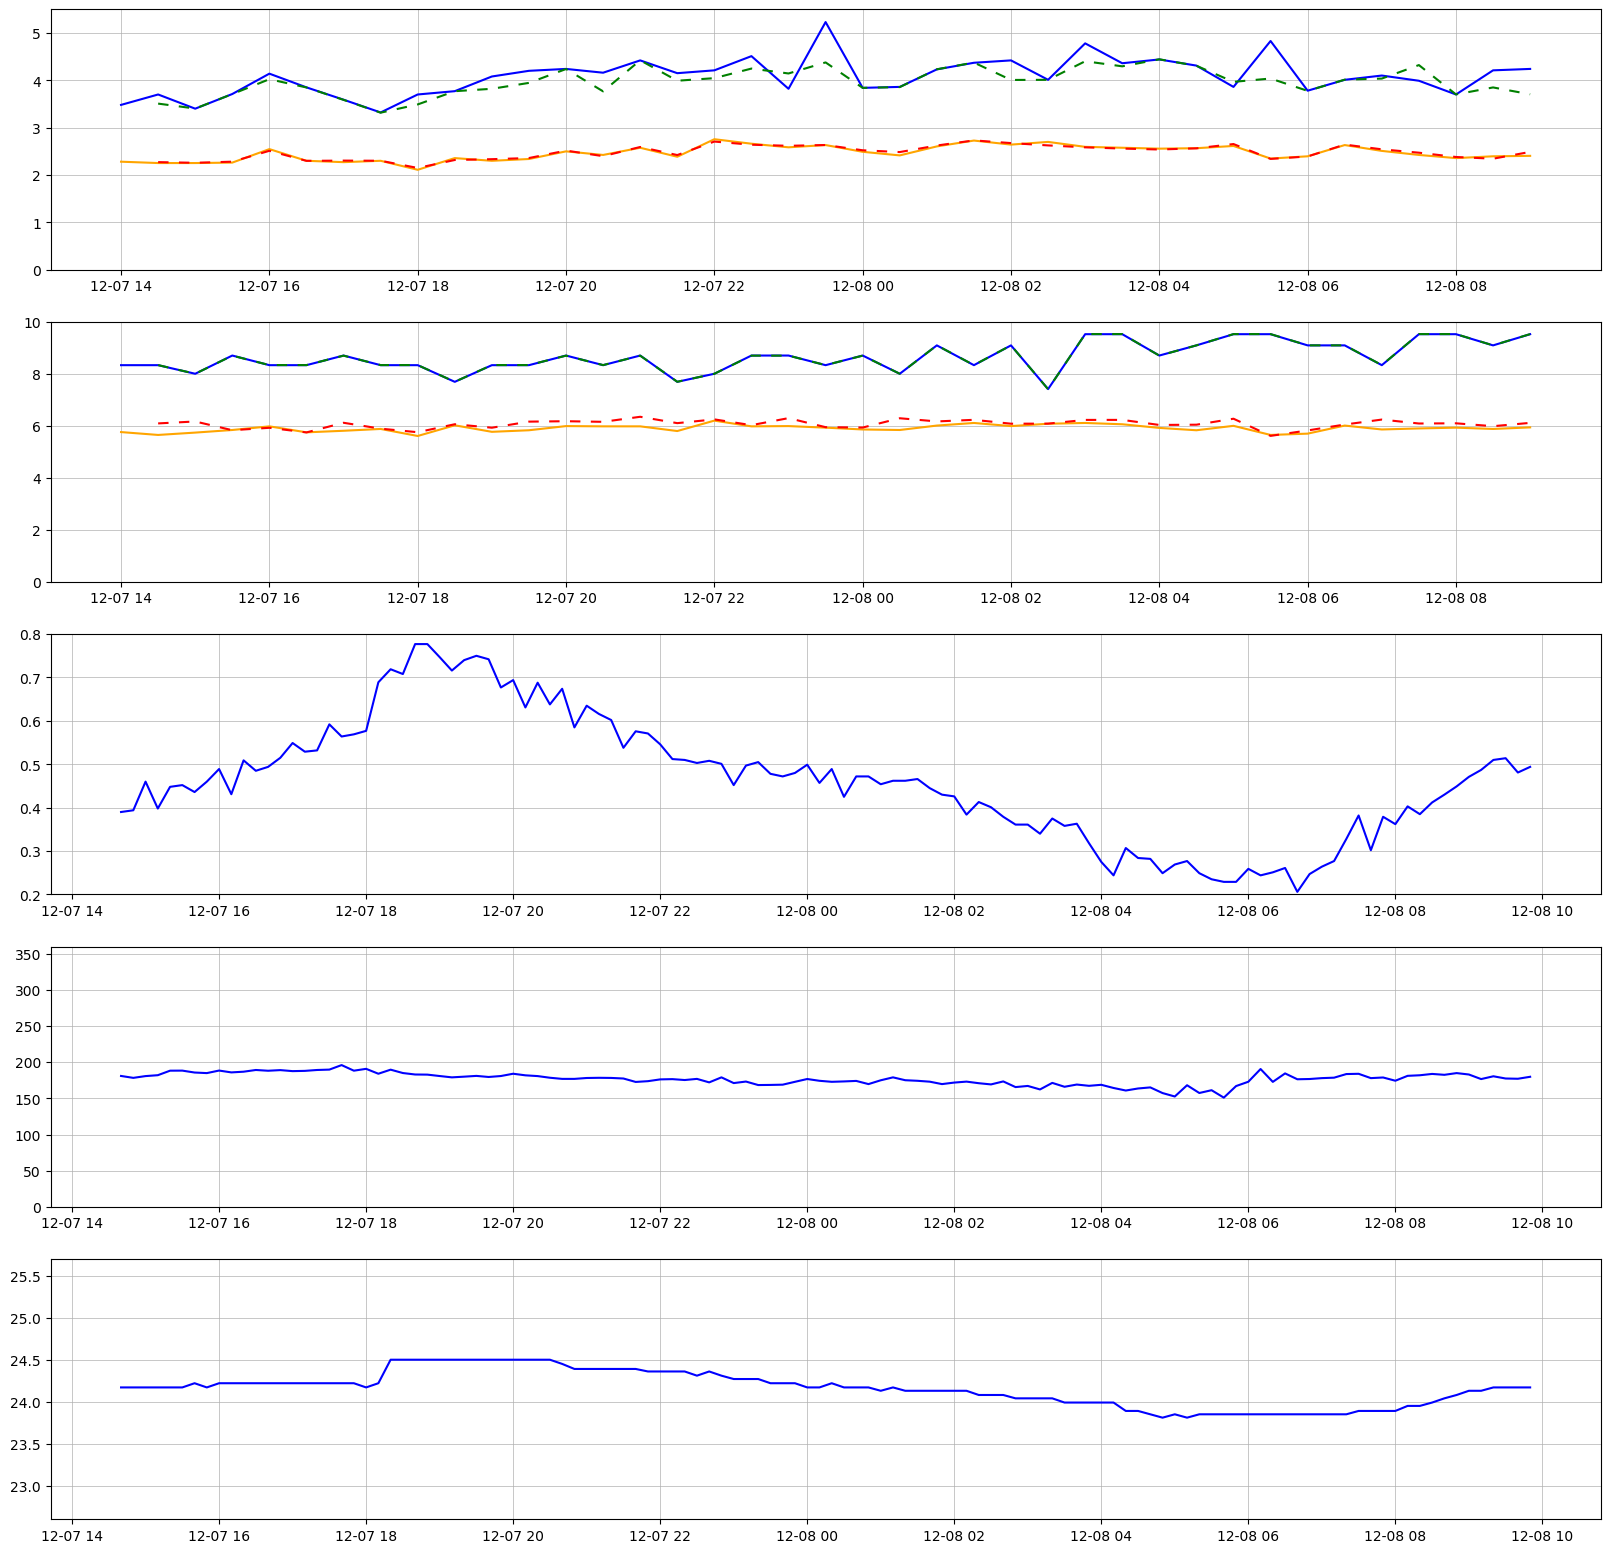

In [27]:
##### MAIN #####

# Get data from selected dates
data = get_data()

# Separate HVA format into two Dataframes
Displacements_DF = data.Displacements_List
Packet_data_DF = data.Packet_List

# Transform DF's into Lists for processing
Displacements_List = []; Packet_List = []
##print('Building Displacement data array')
Displacements_List = Displacements_DF.tolist()
Packet_List = Packet_data_DF.tolist()

Packet_data = []
##print('Building Packet data array')
for val in Packet_List:
    Packet_data.append(val[1:3])
    Packet_data.append(val[3:5])
    Packet_data.append(val[5:7])
    
# Locate records that are OK; have been fixed; or, damaged beyond repair - Refer to DWTP 2.1 p.20
Good_data = [i for i,x in enumerate([x[0:1]for x in Displacements_List]) if x == '-']
Repaired_data = [i for i,x in enumerate([x[0:1]for x in Displacements_List]) if x == '=']
Bad_data = [i for i,x in enumerate([x[0:1]for x in Displacements_List]) if x == '!']

print('{:3s}{:<7d}{:9s}'.format('Of ',len(Displacements_List),' records:'))
print('    ',len(Good_data),' records were received properly from the buoy')
if len(Repaired_data) > 0:
    print('    ',len(Repaired_data),' records were damaged and repaired successfully')
if len(Bad_data) > 0:
    print('    ',len(Bad_data),' records were damaged beyond repair and the data should be discarded')

# Set up the Dataframes that will contain the data extracted from the HEX vectors
F20_df = pd.DataFrame(columns=['F20_time','s_tilde','Smax','No_of_segments'])
F23_df = pd.DataFrame(columns=['F23_time','Match_vector','Sample_number','Hn_1','Nn_1','Wn_1','Hn','Nn','Wn'])
F25_df = pd.DataFrame(columns=['F25_time','Hs','Ti','Te','T1','Tz','T3','Tc','Tp'])
F26_df = pd.DataFrame(columns=['F26_time','Hmax','THmax','Tmax','HTmax','Hsrms','Nw','Nc'])
F29_df = pd.DataFrame(columns=['F29_time','Havg','Hthird','H10','Hmax','THavg','THthird','TH10','THmax'])
F82_df = pd.DataFrame(columns=['F82_time','speed','direction','Tw'])
##FB0_df = pd.DataFrame(columns=['FB0_time','Hs','T1','Tz','Tp','Theta_p','Sigma_p','Hmax_Hsrms','Lat_i','Long_i','Battery_Tw','Speed','Dir'])


# Locate occurrences of 0x7E's in Packet_data - Refer to DWTP 2.1.2 p.21
##print('Locating occurrences of 0x7E in Packet data')
Valu_0x7E_List = [i for i, j in enumerate(Packet_data) if j == '7E']
F29 = 0; FB0 = 0
for i in range(len(Valu_0x7E_List)-1):
    start = Valu_0x7E_List[i]+1; end = Valu_0x7E_List[i+1]
    if end-start > 1:
        Decoded = Packet_data[start:end]
        Decoded_len = len(Decoded)   # Need to check this to ensure correct number of bytes
        
        Found_7D = [m for m, n in enumerate(Decoded) if n == '7D']        # Locate '7D' in packet

        for p in range(len(Found_7D)):
            XOred = hex(int(Decoded[Found_7D[p]+1],16)^int('20',16))      # X'Or the byte after '7D'
            Decoded[Found_7D[p]+1] = XOred[2:].upper()

        for p in range(len(Found_7D)-1,-1,-1): 
            del Decoded[Found_7D[p]]                                      # Remove this '7D' from the packet
            
        Message_Id = Decoded[0][0]+Decoded[1]; CRC_4_Checksum = Decoded[0][1]
        
        if (Message_Id == 'F20'):
            F20_time,s_tilde,Smax,No_of_segments = Do_F20(Decoded)                       # Decode Heave spectrum message
            F20_df = F20_df.append({'F20_time':F20_time,'s_tilde':s_tilde,'Smax':Smax,'No_of_segments':No_of_segments},\
                        ignore_index=True)

        if (Message_Id == 'F23'): 
            F23_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign = Do_F23(Decoded)          # Decode Spectrum synchronisation message
            F23_df = F23_df.append({'F23_time':F23_time,'Match_vector':'-'+Match_vector,'Sample_number':Sample_number,\
                       'Hn_1':Hn_1_sign,'Nn_1':Nn_1_sign,'Wn_1':Wn_1_sign,'Hn':Hn_sign,'Nn':Nn_sign,'Wn':Wn_sign},ignore_index=True)
 
        if (Message_Id == 'F25'):
            F25_time,Hs,Ti,Te,T1,Tz,T3,Tc,Tp = Do_F25(Decoded)         
            F25_df = F25_df.append({'F25_time':F25_time,'Hs':Hs,'Ti':Ti,'Te':Te,'T1':T1,'Tz':Tz,'T3':T3,'Tc':Tc,\
                    'Tp':Tp},ignore_index=True)
        if (Message_Id == 'F26'): 
            F26_time,Hmax,THmax,Tmax,HTmax,Hsrms,Nw,Nc = Do_F26(Decoded)  # Decode online upcrossing wave statistics message                    
            F26_df = F26_df.append({'F26_time':F26_time,'Hmax':Hmax,'THmax':THmax,'Tmax':Tmax,'HTmax':HTmax,
                'Hsrms':Hsrms,'Nw':Nw,'Nc':Nc},ignore_index=True)

        if (Message_Id == 'F29'):
            F29 = 1
            F29_time,Havg,Hthird,H10,Hmax,THthird,TH10,THmax = Do_F29(Decoded)
            F29_df = F29_df.append({'F29_time':F29_time,'Havg':Havg,'Hthird':Hthird,'H10':H10,'Hmax':Hmax,\
                'THthird':THthird,'TH10':TH10,'THmax':THmax},ignore_index=True)

        if (Message_Id == 'F82'):
            F82_time,speed,direction,Tw = Do_F82(Decoded)
            F82_df = F82_df.append({'F82_time':F82_time,'speed':speed,'direction':direction,'Tw':Tw},ignore_index=True)            
            
#        if (Message_Id == 'FB0'):
#            FB0 = 1
#            FB0_time,Hs,T1,Tz,Tp,Theta_p,Sigma_p,Hmax_Hsrms,Lat_i,Long_i,Battery_Tw,Speed,Dir = Do_FB0(Decoded)
#            FB0_df = FB0_df.append({'FB0_time':FB0_time,'Hs':Hs,'T1':T1,'Tz':Tz,'Tp':Tp,'Theta_p':Theta_p,\
#                'Sigma_p':Sigma_p,'Hmax_Hsrms':Hmax_Hsrms,'Lat_i':Lat_i,'Long_i':Long_i,'Battery_Tw':Battery_Tw,\
#                'Speed':Speed,'Dir':Dir},ignore_index=True)
            
# Remove duplicate rows from the Dataframes - this removes all Datawells retransmissions!
F20_df = F20_df.iloc[F20_df.astype(str).drop_duplicates().index]; F20_df = F20_df.reset_index(drop=True)
F23_df = F23_df.drop_duplicates(); F23_df = F23_df.reset_index(drop=True)
F25_df = F25_df.drop_duplicates(); F25_df = F25_df.reset_index(drop=True)
F26_df = F26_df.drop_duplicates(); F26_df = F26_df.reset_index(drop=True)
F29_df = F29_df.drop_duplicates(); F29_df = F29_df.reset_index(drop=True)
F82_df = F82_df.drop_duplicates(); F82_df = F82_df.reset_index(drop=True)
#FB0_df = FB0_df.drop_duplicates(); FB0_df = FB0_df.reset_index(drop=True)

# Locate where Match_vector from F23 occurs in the Displacements list
Position = data.loc[data['Displacements_List'].isin(F23_df['Match_vector'])]

Calc_df = pd.DataFrame(columns=['Calc_time','Hsig','Hmax','Tz','Tp','THsig'])
Matched_values = Position.index.tolist()
if len(Matched_values) > 0:
#######################################################
# Display error report for each record, and print results from various Message Blocks described in DWTP p29 Table 16
    for record in range(len(Matched_values)):
        Status = []; wls = []; north = []; west = []
        Position_list = Position.Displacements_List.tolist()
        Loc = F23_df.loc[F23_df['Match_vector'] == Position_list[record]].index.tolist()
    
        F23_time = datetime.combine(F23_df['F23_time'][Loc[0]].date(),F23_df['F23_time'][Loc[0]].time())
        F23_sample_number = F23_df['Sample_number'][record]

        Status,wls,north,west = Get_Displacements(Matched_values[record],F23_sample_number, Status, Displacements_List)
#        wls = Calc_MWL(wls)           # Apply a correction for Mean Water Level
        f_Mk4 = calc_frequencies()    # calculate frequency values for the Mk4 wave buoy
        f2,Pden2,Tp2 = calc_spectral_parameters(wls)
        Below,Hsig,Hmax,Tz,Tp2,THsig = Do_time_domain(wls,F23_time,Tp2,Matched_values,record)
        Calc_df = Calc_df.append({'Calc_time':F23_time,'Hsig':Hsig,'Hmax':Hmax,'Tz':Tz,'Tp':Tp2,'THsig':THsig},ignore_index=True)
        
        Loc_F25 = F25_df.loc[F25_df['F25_time'] == F23_time].index.tolist()
        F25_time = datetime.combine(F25_df['F25_time'][Loc_F25[0]].date(),F25_df['F25_time'][Loc_F25[0]].time())
        print('{:%Y-%m-%d %H:%M}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}' \
            .format(F25_time,' Hs=',F25_df['Hs'][record],' Ti=',F25_df['Ti'][record],' Te=',F25_df['Te'][record],\
            ' T1=',F25_df['T1'][record],' Tz=',F25_df['Tz'][record],' T3=',F25_df['T3'][record],' Tc=',F25_df['Tc'][record],' Tp=',F25_df['Tp'][record]))

        Loc_F26 = F26_df.loc[F26_df['F26_time'] == F23_time].index.tolist()
        F26_time = datetime.combine(F26_df['F26_time'][Loc_F26[0]].date(),F26_df['F26_time'][Loc_F26[0]].time())
        print('{:%Y-%m-%d %H:%M}{:6s}{:5.2f}{:7s}{:5.2f}{:6s}{:5.2f}{:7s}{:5.2f}{:7s}{:5.2f}{:4s}{:4d}{:4s}{:4d}' \
            .format(F26_time,' Hmax=',F26_df['Hmax'][record],' THmax=',F26_df['THmax'][record],' Tmax=',F26_df['Tmax'][record],\
            ' HTmax=',F26_df['HTmax'][record],' Hsrms=',F26_df['Hsrms'][record],' Nw=',F26_df['Nw'][record],' Nc=',F26_df['Nc'][record]))
        if F29 > 0:
            Loc_F29 = F29_df.loc[F29_df['F29_time'] == F23_time].index.tolist()
            F29_time = datetime.combine(F29_df['F29_time'][Loc_F29[0]].date(),F29_df['F29_time'][Loc_F29[0]].time())
            print('{:%Y-%m-%d %H:%M}{:7s}{:5.2f}{:7s}{:5.2f}{:6s}{:5.2f}{:7s}{:5.2f}{:8s}{:5.2f}{:7s}{:5.2f}{:8s}{:5.2f}'\
              .format(F29_time,' Havg= ',F29_df['Havg'][record],' H1/3= ',F29_df['Hthird'][record],' H10= ',F29_df['H10'][record],\
                ' Hmax= ',F29_df['Hmax'][record],' TH1/3= ',F29_df['THthird'][record],' TH10= ',F29_df['TH10'][record],' THmax= ',F29_df['THmax'][record]))

        Loc_F82 = F82_df.loc[F82_df['F82_time'] == F23_time].index.tolist()
        if Loc_F82:
            F82_time = datetime.combine(F82_df['F82_time'][Loc_F82[0]].date(),F82_df['F82_time'][Loc_F82[0]].time())
            print('{:%Y-%m-%d %H:%M}{:7s}{:5.2f}{:11s}{:5.2f}{:4s}{:5.2f}' \
            .format(F82_time,' Speed=',F82_df['speed'][record],' Direction=',F82_df['direction'][record],' Tw=',F82_df['Tw'][record]))        
    print('-----------------------------------------------------------')
    
plt.figure(figsize=(20,20),dpi=100)
plt.subplot(5, 1, 1)
plt.ylim(bottom=0,top=np.around(max(F26_df['Hmax'])*1.05,decimals=1))
plt.grid(True,linewidth=0.5)
plt.plot(F26_df['F26_time'],F26_df['Hmax'],color='blue')
plt.plot(F25_df['F25_time'],F25_df['Hs']*0.95,color='orange')
plt.plot(Calc_df['Calc_time'],Calc_df['Hmax'],color='green',dashes=[5, 5, 5, 5])
plt.plot(Calc_df['Calc_time'],Calc_df['Hsig'],color='red',dashes=[5, 5, 5, 5])
plt.legend(frameon=False)

plt.subplot(5, 1, 2)
plt.ylim(bottom=0,top=np.around(max(F25_df['Tp'])*1.05,decimals=1))
plt.grid(True,linewidth=0.5)
plt.plot(F25_df['F25_time'],F25_df['Tp'],color='blue')
plt.plot(F25_df['F25_time'],F25_df['Tz'],color='orange')
plt.plot(Calc_df['Calc_time'],Calc_df['Tp'],color='green',dashes=[5, 5, 5, 5]) 
plt.plot(Calc_df['Calc_time'],Calc_df['Tz'],color='red',dashes=[5, 5, 5, 5]) 
plt.legend(frameon=False)

plt.subplot(5, 1, 3)
plt.ylim(bottom=np.around(min(F82_df['speed'])*0.95,decimals=1),top=np.around(max(F82_df['speed'])*1.05,decimals=1))
plt.grid(True,linewidth=0.5)
plt.plot(F82_df['F82_time'],F82_df['speed'],color='blue')
plt.legend(frameon=False)

plt.subplot(5, 1, 4)
plt.ylim(bottom=0,top=360)
plt.grid(True,linewidth=0.5)
plt.plot(F82_df['F82_time'],F82_df['direction'],color='blue')
plt.legend(frameon=False)

plt.subplot(5, 1, 5)
plt.ylim(bottom=np.around(min(F82_df['Tw'])*0.95,decimals=1),top=np.around(max(F82_df['Tw'])*1.05,decimals=1))
plt.grid(True,linewidth=0.5)
plt.plot(F82_df['F82_time'],F82_df['Tw'],color='blue')
plt.legend(frameon=False)

In [28]:
Start_File = get_file()
date_str = Start_File.split('}')[1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ") ### + timedelta(hours=10)

End_File = get_file()
date_str = End_File.split('}')[1].split('.')[0]
End_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ") ### + timedelta(hours=10)
Front_part = Start_File.split('}')[0]
Extension = Start_File.split('}')[1].split('.')[1]

Days = (End_time-Start_time).days

data = pd.DataFrame([])

for dt in Date_range(Start_time, End_time):
    Input_File = Front_part+'}'+dt.strftime("%Y-%m-%dT%Hh%MZ")+'.'+Extension

    error_to_catch = getattr(__builtins__,'FileNotFoundError', IOError)

    try:
# Read data from the HVA file
#        data = data.append(pd.read_csv(Input_File, names=['Cycle_counter','Displacements_List','Packet_List'], header=None),ignore_index=True)
        print('Reading data from HVA file:',Input_File)
    except error_to_catch:
        print('WARNING... ',Input_File,' NOT Found!')

Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-07T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-08T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-09T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-10T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-11T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-12T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-13T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-14T04h36Z.hva
Reading data from HVA file: C:/QGHL/Wave_data/Bris/HVA/brisbane_4183}2018-12-15T04h36Z.hva
